In [1]:
#Local files(same folder)
from docker.consumer.modelFunctions import *
from docker.producer.readingFunctions import *

#Python libraries
import timeit
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split  
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.externals import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alejandrohernandezmunuera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#dataSet = obtain_mailPathList('Data', untar=True, labeled=True)
dataSet = obtain_mailPathList('Data', labeled=True)
df = pd.DataFrame(data=dataSet, columns=["filepath", "label"])

#Read mail files
df['file'] = df.filepath.map(readFilepath).astype(str)

#Divide metadata and content
df['pre_info'] = df.file.map(info_part)
df['content'] = df.file.map(content_part)

#Remove data points without content found
#df[df['content']=='']
cond = df['content']!=''
df = df[cond]

SPAM    32928
HAM     19088
Name: label, dtype: int64


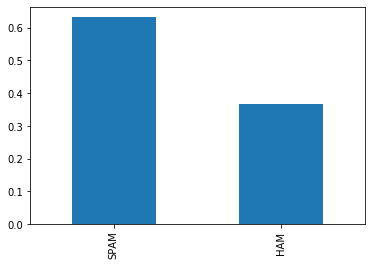

In [4]:
#Check if data is balanced
labelCount = df['label'].value_counts()
print(labelCount)
barplot = (labelCount/labelCount.sum()).plot(kind='bar')

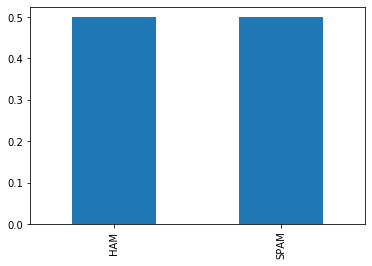

In [4]:
#Randomly discard SPAM datapoints to have a uniform distribution
#Tricky step: do not introduce bias

#Separate based on label
dfS = df[df['label']=='SPAM']
dfH = df[df['label']=='HAM']
#Subsample the larger set
dfSPAMsample = dfS.sample(frac=dfH.size/dfS.size)

#Concatenate sets and reset index
dfBalance = pd.concat([dfSPAMsample, dfH])
dfBalance = dfBalance.reset_index(drop=True)

#Show distribution
labelCount = dfBalance['label'].value_counts()
barplot = (labelCount/labelCount.sum()).plot(kind='bar')

In [5]:
#Show table content
dfBalance

,filepath,label,file,pre_info,content
0,Data/SPAM/GP/part4/msg7799.eml,SPAM,"From: ""luckydayvp2004"" <luckydayvp2004@yahoo.c...","From: ""luckydayvp2004"" <luckydayvp2004@yahoo.c...","<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E..."
1,Data/SPAM/GP/part2/msg4650.eml,SPAM,From: <exchange-robot@paypal.com>\nTo: <paliou...,From: <exchange-robot@paypal.com>\nTo: <paliou...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4.01 T..."
2,Data/SPAM/BG/2004/10/1099198816.24383_842.txt,SPAM,Return-Path: <qaylct@mails.ch>\nDelivered-To: ...,Return-Path: <qaylct@mails.ch>\nDelivered-To: ...,<html>\n\t<head>\n\t\t<title>annoy</title>\n\t...
3,Data/SPAM/BG/2004/09/1095715098.11795_203.txt,SPAM,Return-Path: <ppjetcwa@yahoo.com>\nDelivered-T...,Return-Path: <ppjetcwa@yahoo.com>\nDelivered-T...,--0-8178544771-9704866217=:63695\nContent-Type...
4,Data/SPAM/SH/HP/prodmsg.2.436895.200571,SPAM,Received: from qznet.biz (72.26.221.23)\n by ...,Received: from qznet.biz (72.26.221.23)\n by ...,This is a multi-part message in MIME format\n\...
...,...,...,...,...,...
38171,Data/HAM/lokay-m/enron_t_s/22,HAM,Message-ID: <13277423.1075844086672.JavaMail.e...,Message-ID: <13277423.1075844086672.JavaMail.e...,"Please join me on Thursday, October 26, from 5..."
38172,Data/HAM/lokay-m/enron_t_s/149,HAM,Message-ID: <7218935.1075854998012.JavaMail.ev...,Message-ID: <7218935.1075854998012.JavaMail.ev...,"\nPlease join Dave Neubauer on Wednesday, Augu..."
38173,Data/HAM/lokay-m/enron_t_s/171,HAM,Message-ID: <32950741.1075854998588.JavaMail.e...,Message-ID: <32950741.1075854998588.JavaMail.e...,"Hey guys, \n\nPlease review these and let me k..."
38174,Data/HAM/lokay-m/enron_t_s/185,HAM,Message-ID: <21573677.1075854998959.JavaMail.e...,Message-ID: <21573677.1075854998959.JavaMail.e...,"Please join me for a floor meeting on June 14,..."


In [6]:
#Train model: Tf-idf + Bayes

#Train-test split
X = dfBalance['content']
y = dfBalance['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

#TODO: Check other prepocessing options: word2vec, bag of words, doc2vec
clf_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(tokenizer=clean_email, stop_words='english')),
    ('classificador', MultinomialNB())])

#Train
clf_pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function clean_email at 0x7fb1bd4acef0>,
                                 use_idf=True, vocabulary=None)),
                ('classificador',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
      

In [7]:
#Performance on test set

#Predict test data
tic=timeit.default_timer()

y_pred = clf_pipeline.predict(X_test)

toc=timeit.default_timer()
model1time=toc - tic
print(f"Time spent to predict test set: {model1time}")#other processes might interfere

#Print performance metrics: confusion matrix, precision, recall, f1-score, accuracy
def printModelMetrics(label,pred,posLabels):
    print(metrics.confusion_matrix(label, pred, labels=posLabels))
    print(metrics.classification_report(label, pred, labels=posLabels))
    print(metrics.accuracy_score(label, pred))
    
printModelMetrics(y_test,y_pred,classes)

Time spent to predict test set: 124.520981522
[[5679   68]
 [  50 5656]]
              precision    recall  f1-score   support

        SPAM       0.99      0.99      0.99      5747
         HAM       0.99      0.99      0.99      5706

    accuracy                           0.99     11453
   macro avg       0.99      0.99      0.99     11453
weighted avg       0.99      0.99      0.99     11453

0.9896970226141623


In [8]:
#Model exploration: Find out which words are more important in the classification

vectorizer= clf_pipeline.named_steps['tfidf_vectorizer']
feature_names = vectorizer.get_feature_names()

classifier = clf_pipeline.named_steps['classificador']

wNumber = 10
top_features = sorted(zip(classifier.coef_[0], feature_names))[-wNumber:]
for coef, feat in top_features:
        print(coef, feat)

-6.969050729176774 tr
-6.906825220317894 e
-6.874067170667888 content
-6.742242096180259 nbsp
-6.652834372970496 http
-6.61765347849213 html
-6.599169997089252 td
-6.058163726528697 font
-5.595654716940808 d
-5.336631058216161 br


In [9]:
#Predict specific data point with prob

def predict_content(pipeline, text):
    pred = pipeline.predict([text])
    prob  = np.max(pipeline.predict_proba([text]))
    print("Text:")
    print(text)
    print("\n")
    print(f"Predicted label: {pred} with probability {prob*100:.2f}%")


indexToPredict = 14
predict_content(clf_pipeline, X_test.iloc[indexToPredict])
print(f"Real label: {y_test.iloc[indexToPredict]}")

Text:
Vasant,

Yes, it's perfect. Please, indicate that the wording was unfortunate.

Vince





Vasant Shanbhogue
03/08/2001 11:20 AM
To: Vince J Kaminski/HOU/ECT@ECT
cc:  
Subject: RE: Weekly report

Hi Vince,

 regarding David Port's response to Kevin Kindall's email, I feel that I 
should respond, at least to make our position clear.  Please indicate if the 
following response is appropriate -------

"Hi David,

  I understand that you were slightly upset over a comment Kevin Kindall made 
in one of his weekly reports.  The intention was never to disparage anybody.  
It is just that since Research gets data from a large number of sources, we 
feel obligated to the data donor to ask any requester for clarification of 
need.  I completely understand that RAC typically has access to much 
sensitive information and they have a right to know much information.  We 
just want to make sure there is open flow of information (it is in 
everybody's best interests and the company's best intere

In [10]:
#Save model to file
saveSpamModel(clf_pipeline)

#Load from file
joblib_model = loadSpamModel()

#Use loaded from file
predict_content(joblib_model, X_test.iloc[indexToPredict])
print(f"Real label: {y_test.iloc[indexToPredict]}")

Text:
Vasant,

Yes, it's perfect. Please, indicate that the wording was unfortunate.

Vince





Vasant Shanbhogue
03/08/2001 11:20 AM
To: Vince J Kaminski/HOU/ECT@ECT
cc:  
Subject: RE: Weekly report

Hi Vince,

 regarding David Port's response to Kevin Kindall's email, I feel that I 
should respond, at least to make our position clear.  Please indicate if the 
following response is appropriate -------

"Hi David,

  I understand that you were slightly upset over a comment Kevin Kindall made 
in one of his weekly reports.  The intention was never to disparage anybody.  
It is just that since Research gets data from a large number of sources, we 
feel obligated to the data donor to ask any requester for clarification of 
need.  I completely understand that RAC typically has access to much 
sensitive information and they have a right to know much information.  We 
just want to make sure there is open flow of information (it is in 
everybody's best interests and the company's best intere

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

In [11]:
#Train second model: bag of words + SVM

#Design pipeline
clf_pipeline2 = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=clean_email, stop_words='english')),
    #('scaler', StandardScaler()), #TODO: normalize data techniques
    ('classificador', svm.SVC())])#svm.SVC(C=0.1, kernel='linear') #TODO: try different kernels

#Train model
clf_pipeline2.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function clean_email at 0x7fb1bd4acef0>,
                                 vocabulary=None)),
                ('classificador',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
            

In [12]:
#Performance on test set

#Predict test data
tic=timeit.default_timer()

y_pred = clf_pipeline2.predict(X_test)

toc=timeit.default_timer()
model2time= toc - tic
print(f"Time spent to predict test set: {model2time}")#other processes might interfere

#Print metrics
printModelMetrics(y_test,y_pred,classes)

Time spent to predict test set: 226.4817312749999
[[4446 1301]
 [  15 5691]]
              precision    recall  f1-score   support

        SPAM       1.00      0.77      0.87      5747
         HAM       0.81      1.00      0.90      5706

    accuracy                           0.89     11453
   macro avg       0.91      0.89      0.88     11453
weighted avg       0.91      0.89      0.88     11453

0.8850956081376059
